In [ ]:
import numpy as np
import pandas as pd
import re

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from google.colab import drive
drive.mount('/content/gdrive')

#grievances_df = pd.read_csv('/content/gdrive/MyDrive/DSSI/Palm_Oil_Grievances/Data/palm_oil_grievance_logs.csv')

#shared drive version at everyone can set up
grievances_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
grievances_df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,426,Wilmar International,NaN,Closed,8/19/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Sumatra Jaya Agro Lestari (SJAL), a subsidiary...",NaN,NaN,NaN,Alleged construction of canal to prepare for d...,Dialogue initiated with PT Sumatra Jaya Agro L...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN
426,427,Wilmar International,NaN,Closed,7/1/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Patiware, a subsidiary of GAMA Plantation",NaN,NaN,NaN,NaN,Dialogue initiated with Ganda Group on the fir...,http://www.greenomics.org/docs/The%20Grievance...,NaN
427,428,Wilmar International,NaN,Closed,5/30/2015,NaN,NaN,NaN,NaN,Action Network - Forest Heroes,Setia Agrindo Lestari (SAL) an affiliate* of F...,NaN,NaN,NaN,NaN,Dialogue initiated with First Resources in the...,https://www.thejakartapost.com/news/2015/05/12...,NaN
428,429,Wilmar International,NaN,Closed,6/5/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,Sawit Sumbermas Sarana (SSS),NaN,NaN,NaN,Alleged clearance of potential High Carbon Sto...,Following a couple of NGO reports about Sawit ...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN


In [ ]:
grievances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   pk                         430 non-null    int64 
 1   source                     430 non-null    object
 2   internal_id                343 non-null    object
 3   status                     430 non-null    object
 4   submitted_on               430 non-null    object
 5   accepted_on                88 non-null     object
 6   last_updated_on            340 non-null    object
 7   country                    171 non-null    object
 8   region                     160 non-null    object
 9   complainants               422 non-null    object
 10  respondents                430 non-null    object
 11  respondent_sector          168 non-null    object
 12  respondent_parent_company  121 non-null    object
 13  respondent_supplier        171 non-null    object
 14  summary   

In [ ]:
!pip install gensim

## Duplicate Testing

In [209]:
grievances_df['is_duplicate'] = grievances_df['summary'].dropna().duplicated()

grievances_df[grievances_df['is_duplicate'] == True]

,0
pk,17
source,17
internal_id,15
status,17
submitted_on,17
accepted_on,0
last_updated_on,15
country,0
region,0
complainants,17


In [ ]:
# Code partly sourced from: https://www.datacamp.com/tutorial/discovering-hidden-topics-python

#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges']

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english') + stopwords_extra)
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        print(i)
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


In [ ]:
#summary = grievances_df['summary'].dropna().tolist()

#preprocessed_summary = preprocess_data(summary)
#preprocessed_summary

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

## Compute Coherence Values

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Coherence Predictions

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Load and preprocess the data to create clean_text
document_list, titles = load_data_from_dataframe(grievances_df['summary'])
clean_text = preprocess_data(document_list)


start,stop,step=2,12,1

Total Number of Documents: 387
That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.
The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges th

In [ ]:
summary = grievances_df['summary'].dropna().tolist()

# LSA Model
number_of_topics=7
words=10
document_list, titles = load_data_from_dataframe(grievances_df['summary'])
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
model.print_topics()


Total Number of Documents: 387
That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.
The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges th

[(0,
  '-0.330*"land" + -0.228*"forest" + -0.210*"area" + -0.193*"plantat" + -0.162*"right" + -0.161*"principl" + -0.146*"plant" + -0.131*"oper" + -0.130*"clear" + -0.124*"2"'),
 (1,
  '0.241*"grower" + 0.200*"us" + -0.196*"forest" + 0.179*"small" + 0.163*"river" + 0.159*"holder" + -0.151*"plantat" + 0.140*"electr" + 0.134*"even" + 0.128*"work"'),
 (2,
  '0.337*"plantat" + 0.247*"eof" + -0.227*"land" + 0.207*"mill" + 0.188*"illeg" + 0.173*"investig" + 0.146*"supplier" + 0.140*"gar" + 0.137*"grievanc" + 0.128*"2016"'),
 (3,
  '0.260*"worker" + 0.221*"ioi" + 0.219*"land" + -0.187*"forest" + 0.170*"complaint" + 0.170*"rspo" + -0.136*"oper" + -0.135*"right" + -0.135*"principl" + 0.129*"1"'),
 (4,
  '0.674*"worker" + 0.240*"employ" + 0.207*"casual" + 0.205*"daili" + 0.187*"provid" + -0.171*"land" + 0.161*"bpj" + 0.140*"fail" + 0.126*"work" + 0.106*"agreement"'),
 (5,
  '0.285*"deforest" + 0.272*"respons" + 0.260*"earth" + 0.257*"mighti" + 0.245*"rapid" + -0.204*"land" + 0.170*"ha" + 0.166*"

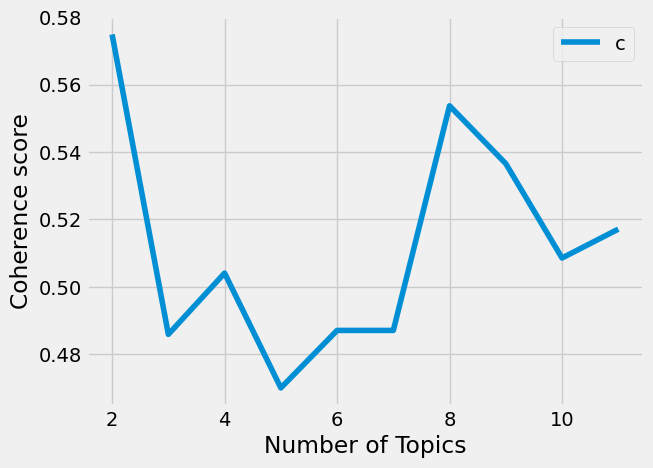

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

# Model Creation

In [ ]:
summary = grievances_df['summary'].dropna().tolist()

# LSA Model
number_of_topics = 8
words = 10
document_list, titles = load_data_from_dataframe(grievances_df['summary'])
clean_text=preprocess_data(document_list)
lsamodel=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 387
That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.
The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges th

## Raw Results

In [ ]:
for i, topic in model.print_topics(num_topics=number_of_topics, num_words=words):
    print(f"Topic {i}: {topic}\n")

Topic 0: -0.330*"land" + -0.228*"forest" + -0.210*"area" + -0.193*"plantat" + -0.162*"right" + -0.161*"principl" + -0.146*"plant" + -0.131*"oper" + -0.130*"clear" + -0.124*"2"

Topic 1: 0.241*"grower" + 0.200*"us" + -0.196*"forest" + 0.179*"small" + 0.163*"river" + 0.159*"holder" + -0.151*"plantat" + 0.140*"electr" + 0.134*"even" + 0.128*"work"

Topic 2: 0.337*"plantat" + 0.247*"eof" + -0.227*"land" + 0.207*"mill" + 0.188*"illeg" + 0.173*"investig" + 0.146*"supplier" + 0.140*"gar" + 0.137*"grievanc" + 0.128*"2016"

Topic 3: 0.260*"worker" + 0.221*"ioi" + 0.219*"land" + -0.187*"forest" + 0.170*"complaint" + 0.170*"rspo" + -0.136*"oper" + -0.135*"right" + -0.135*"principl" + 0.129*"1"

Topic 4: 0.674*"worker" + 0.240*"employ" + 0.207*"casual" + 0.205*"daili" + 0.187*"provid" + -0.171*"land" + 0.161*"bpj" + 0.140*"fail" + 0.126*"work" + 0.106*"agreement"

Topic 5: 0.285*"deforest" + 0.272*"respons" + 0.260*"earth" + 0.257*"mighti" + 0.245*"rapid" + -0.204*"land" + 0.170*"ha" + 0.166*"gar"

# Coherence Score

In [ ]:
dictionary, doc_term_matrix = prepare_corpus(clean_text)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
coherence_score

0.5574497302403227

# Visualizations

In [ ]:
model_name = "LSA"

## Create Dataframe with Results

In [ ]:
#Input: LSA model, corpus (in this case TFIDF matrix), text (summary column)
#Output: Dataframe consisting of every row
def format_topics_sentences(model=None, corpus=None, texts=None):
    # Collect rows in a list
    rows = []

    for i, doc in enumerate(model[corpus]):
        # Create Dict for Topic contributions, and normalize values
        total_weight = sum(abs(weight) for _, weight in doc)
        topic_dist = {
            f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2) # Finds and normalizes weights for each topic
            for topic_id, weight in doc
        }

        # Create Dict for Multi-Label Binary Classifcation
        topic_binary = {
            f"Topic_{topic_id}_Indicate": 0
            for topic_id, weight in doc
        }

        shared_perc = 0 # Shared contribution amongst topics given to document
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
        dom_topic_num = 0
        dom_topic_perc = 0.0
        is_outlier = False

        # Get Dominant Topics
        itr = 0
        while (shared_perc < 50.0):
            # Get Topic Number and Topic Percentage
            topic_num, topic_perc = sorted_doc[itr]
            topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
            shared_perc += topic_perc
            topic_binary[f"Topic_{topic_num}_Indicate"] = 1  # Multi-Label Binary Classifcation

            # Get Prime Dominant Topic
            if itr == 0:
                dom_topic_num = topic_num
                dom_topic_perc =  topic_perc
            itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True

        topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])

        # Create Row for Document
        row = {
            'Dominant_Topic': int(dom_topic_num),
            'Perc_Contribution': dom_topic_perc,
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row.update(topic_dist) # Add individual topic contributions
        row.update(topic_binary) # Add Multi-Label Binary Classifcation for topics
        rows.append(row)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [201]:
# Grab TFIDF matrix from prev functions
dictionary , doc_term_matrix = prepare_corpus(clean_text)

# Format
dominant_topic_df = format_topics_sentences(model=lsamodel, corpus=doc_term_matrix, texts=document_list).reset_index()
dominant_topic_df.head(5)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_6_Perc,Topic_7_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate,Topic_6_Indicate,Topic_7_Indicate
0,0,4,29.79,"worker, employ, casual, daili, provid, land, b...",That the Respondent allegedly transferred the ...,False,2,21.86,19.41,2.45,...,10.48,0.12,1,0,0,0,1,0,0,0
1,1,4,27.95,"worker, employ, casual, daili, provid, land, b...",The Complainant alleges that the Respondent ha...,False,2,23.80,0.47,6.51,...,8.33,5.15,1,0,0,0,1,0,0,0
2,2,0,43.86,"land, forest, area, plantat, right, principl, ...",1.The Complainant alleges that the Respondent ...,False,2,43.86,11.89,18.77,...,10.90,0.62,1,0,1,0,0,0,0,0
3,3,0,34.67,"land, forest, area, plantat, right, principl, ...",The Respondent's Corporate Social Responsibili...,False,2,34.67,15.46,24.69,...,0.37,1.53,1,0,1,0,0,0,0,0
4,4,0,43.94,"land, forest, area, plantat, right, principl, ...",The Complainant alleges that the Respondent br...,False,2,43.94,8.77,14.08,...,2.19,7.43,1,0,0,0,0,1,0,0


## Data Exploration

In [ ]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 5]

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_6_Perc,Topic_7_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate,Topic_6_Indicate,Topic_7_Indicate
12,12,5,31.65,"deforest, respons, earth, mighti, rapid, land,...",Alleged failure by the Respondent Company to c...,False,2,28.42,4.79,4.12,...,6.09,9.71,1,0,0,0,0,1,0,0
178,178,5,28.04,"deforest, respons, earth, mighti, rapid, land,...",Allegations of forest clearing by palm oil sup...,False,3,14.98,9.95,15.60,...,5.90,11.59,1,0,1,0,0,1,0,0
180,180,5,28.41,"deforest, respons, earth, mighti, rapid, land,...",Allegations of peat clearance and social confl...,False,2,26.98,13.73,4.40,...,8.11,17.24,1,0,0,0,0,1,0,0
182,182,5,33.73,"deforest, respons, earth, mighti, rapid, land,...","In the report ""A Deadly Trade-Off"", Greenpeace...",False,3,14.93,7.37,10.55,...,1.61,15.06,1,0,0,0,0,1,0,1
183,183,5,23.72,"deforest, respons, earth, mighti, rapid, land,...",HCS and HCV clearance in concession of PT Syau...,False,3,15.41,8.81,6.84,...,6.27,16.02,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,358,5,35.77,"deforest, respons, earth, mighti, rapid, land,...",Alleged deforestation by PT Gerbang Benua Raya...,False,2,7.81,5.99,13.35,...,7.97,18.52,0,0,0,0,0,1,0,1
363,363,5,33.92,"deforest, respons, earth, mighti, rapid, land,...",Alleged deforestation by PT Pipit Mutiara Inda...,False,2,13.14,5.50,1.10,...,8.49,19.85,0,0,0,0,0,1,0,1
365,365,5,30.86,"deforest, respons, earth, mighti, rapid, land,...","Alleged deforestation by Rendi Permata Raya, a...",False,3,8.47,8.03,18.03,...,8.21,17.25,0,0,1,0,0,1,0,1
383,383,5,29.05,"deforest, respons, earth, mighti, rapid, land,...","i. PT Rimba Harapan Saksti (RHS), PT Sarana Ti...",False,2,13.79,8.30,0.03,...,4.17,8.44,0,0,0,1,0,1,0,0


## Avg Dominant Topic Contribution

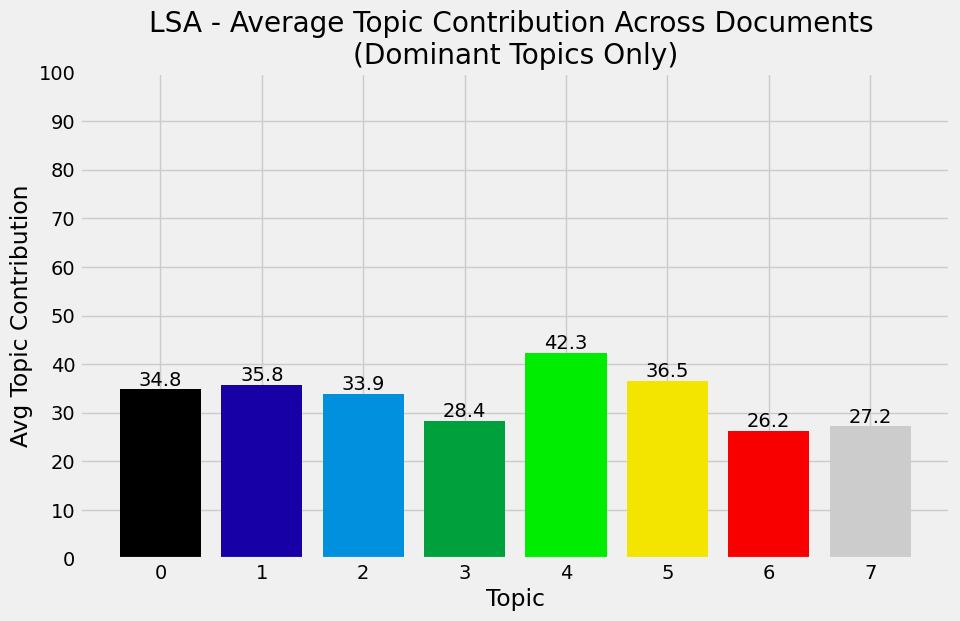

In [ ]:
# Prepare data
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

## Topic Frequency

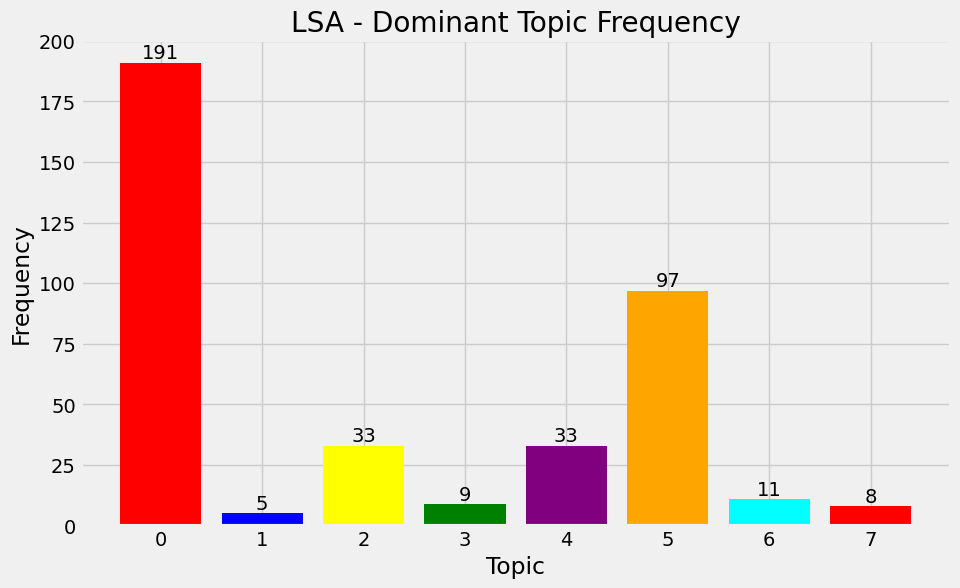

In [ ]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Topic Distribution per Doc

In [ ]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['index'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

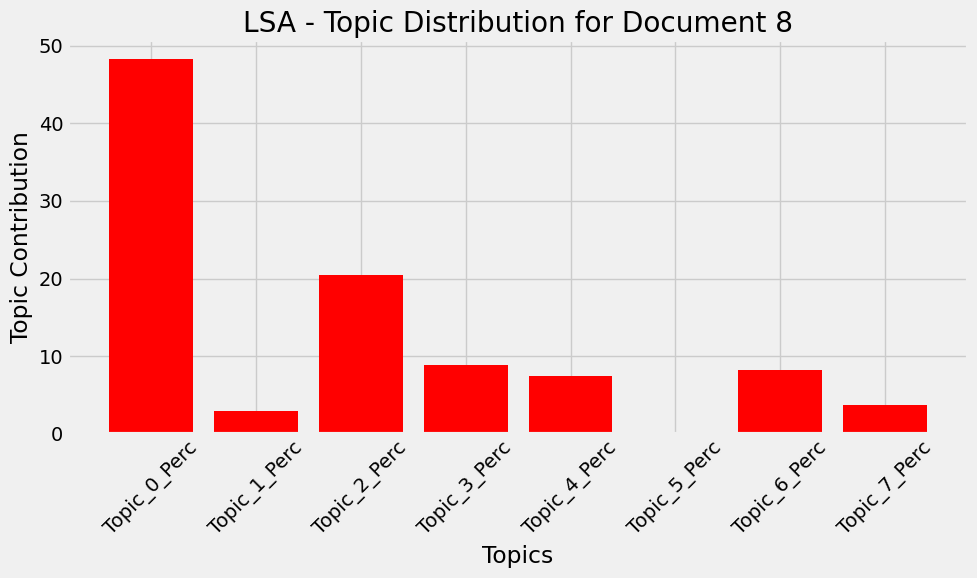

In [ ]:
topic_dist_doc(dominant_topic_df, number_of_topics, 8)

## Word Clouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordclouds', n_topics=number_of_topics)

Output hidden; open in https://colab.research.google.com to view.

## Overall Dominant Topic % Share

Text(0, 0.5, 'Number of Documents')

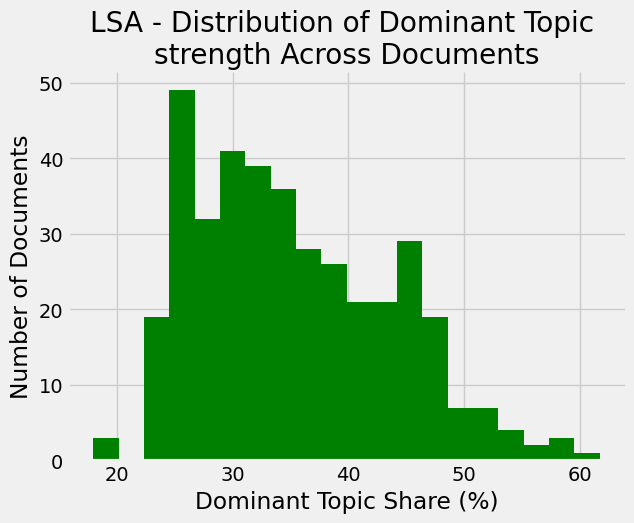

In [ ]:
# Displays every doc's dominant topic share as a percentage compared to its other non-dominant topics
# Basically how much weight the dominant topic have throughout each of the documents
dominant_topic_df['Perc_Contribution'].plot(kind='hist', bins=20, title='Perc_Contribution', color='green')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.title(f"{model_name} - Distribution of Dominant Topic \nstrength Across Documents")
plt.xlabel("Dominant Topic Share (%)")
plt.ylabel("Number of Documents")